In [1]:
import copy
import json
import numbers
import os
import os.path as osp
from json import JSONDecodeError

import numpy as np
import pandas as pd
import scipy
import scipy.interpolate

In [2]:
def _flatten_dict(dt, delimiter="/"):
    dt = copy.deepcopy(dt)
    while any(isinstance(v, dict) for v in dt.values()):
        remove = []
        add = {}
        for key, value in dt.items():
            if isinstance(value, dict):
                for subkey, v in value.items():
                    add[delimiter.join([key, subkey])] = v
                remove.append(key)
        dt.update(add)
        for k in remove:
            del dt[k]
    return dt

def _parse(p):
    dataframe = []
    fn = p.split("/")[-1]
    with open(osp.join(p, "result.json"), "r") as f:
        for l in f:
            data = json.loads(l)
            data = _flatten_dict(data)
            data["file_name"] = fn
            dataframe.append(data)
    dataframe = pd.DataFrame(dataframe)
    dataframe = dataframe.drop(columns=["config/multiagent/policies/default"])
    # print(len(dataframe), list(dataframe.keys()), dataframe["config/multiagent/policies/default"])
    return dataframe


def parse(root):
    """
    Read and form data into a dataframe
    """
    df = []
    paths = [osp.join(root, p) for p in os.listdir(root) if osp.isdir(osp.join(root, p))]
    for pi, p in enumerate(paths):
        print(f"Finish {pi + 1}/{len(paths)} trials.")
        try:
            ret = _parse(p)
        except (FileNotFoundError, JSONDecodeError):
            print("Path {} not found. Continue.".format(p))
            continue
        if ret is not None:
            df.append(ret)
    if not df:
        print("No Data Found!")
        return None
    df = pd.concat(df)
    return df

def smooth(data, num_points=200, interpolate_x="timesteps_total", interpolate_y=None, y_span=1, splitter="file_name"):
    data = data.copy()
    if num_points <= 0:
        return data
    trial_list = [j for i, j in data.groupby(splitter)]
    num_points_ = int(max(len(df) for df in trial_list))
    print("Found {} points, draw {} points.".format(num_points_, num_points))
    num_points = min(num_points, num_points_)
    range_min = min(df[interpolate_x].min() for df in trial_list)
    range_max = max(df[interpolate_x].max() for df in trial_list)
    interpolate_range = np.linspace(range_min, range_max, num_points)
    keys = data.keys()
    new_trial_list = []
    for df in trial_list:
        mask = np.logical_and(df[interpolate_x].min() < interpolate_range, interpolate_range < df[interpolate_x].max())
        mask_rang = interpolate_range[mask]
        if len(df) > 1:
            new_df = {}
            df = df.reset_index(drop=True)
            for k in keys:
                if isinstance(df[k][0], numbers.Number):
                    try:
                        new_df[k] = scipy.interpolate.interp1d(df[interpolate_x], df[k])(mask_rang)
                    except ValueError:
                        continue
                elif isinstance(df[k][0], list):
                    continue
                else:
                    new_df[k] = df[k].unique()[0]
            new_trial_list.append(pd.DataFrame(new_df))
        else:
            new_trial_list.append(df)
    return pd.concat(new_trial_list, ignore_index=True)


In [3]:
def get_useless_keys(ret):
    useless_keys = [
        k for k in ret.keys() 
        if (
            "config" in k and
            k != "config/env" and 
            k != "config/env_config/start_seed"
        ) or (
            "timers" in k
        ) or (
            "sampler_perf" in k
        ) or (
            "hist_stats" in k
        ) or (
            "_min_" in k
        ) or (
            "_max_" in k
        ) or (
            "_mean_max" in k
        ) or (
            "_mean_min" in k
        )
    ]
    return useless_keys

# Read raw data and prepare some intermediate CSV files

In [4]:
for path, name in {
    "copo_dist": "CoPO",
    "copo_ccppo": "MF-CCPPO",
    "copo_ccppo_concat": "Concat-CCPPO",
}.items():
    df = parse(path)
    new_df = smooth(df)
    new_df["algo"] = name
    new_df.to_csv("{}.csv".format(path))
    del df
    del new_df
    print("Finished ", name)

Finish 1/48 trials.
Finish 2/48 trials.
Finish 3/48 trials.
Finish 4/48 trials.
Finish 5/48 trials.
Finish 6/48 trials.
Finish 7/48 trials.
Finish 8/48 trials.
Finish 9/48 trials.
Finish 10/48 trials.
Finish 11/48 trials.
Finish 12/48 trials.
Finish 13/48 trials.
Finish 14/48 trials.
Finish 15/48 trials.
Finish 16/48 trials.
Finish 17/48 trials.
Finish 18/48 trials.
Finish 19/48 trials.
Finish 20/48 trials.
Finish 21/48 trials.
Finish 22/48 trials.
Finish 23/48 trials.
Finish 24/48 trials.
Finish 25/48 trials.
Finish 26/48 trials.
Finish 27/48 trials.
Finish 28/48 trials.
Finish 29/48 trials.
Finish 30/48 trials.
Finish 31/48 trials.
Finish 32/48 trials.
Finish 33/48 trials.
Finish 34/48 trials.
Finish 35/48 trials.
Finish 36/48 trials.
Finish 37/48 trials.
Finish 38/48 trials.
Finish 39/48 trials.
Finish 40/48 trials.
Finish 41/48 trials.
Finish 42/48 trials.
Finish 43/48 trials.
Finish 44/48 trials.
Finish 45/48 trials.
Finish 46/48 trials.
Finish 47/48 trials.
Finish 48/48 trials.
F

/var/folders/vm/zd7wj82n7vs_kxn_n7pnqdw40000gn/T/ipykernel_74934/2866531266.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["algo"] = name


Finished  Concat-CCPPO


In [ ]:
for path, name in {
    "cl": "CL",
}.items():
    df = parse(path)
    new_df = smooth(df)
    new_df["algo"] = name
    new_df.to_csv("{}.csv".format(path))
    del df
    del new_df
    print("Finished ", name)

Finish 1/48 trials.
Finish 2/48 trials.
Finish 3/48 trials.
Finish 4/48 trials.
Finish 5/48 trials.
Finish 6/48 trials.
Finish 7/48 trials.
Finish 8/48 trials.
Finish 9/48 trials.
Finish 10/48 trials.
Finish 11/48 trials.
Finish 12/48 trials.
Finish 13/48 trials.
Finish 14/48 trials.
Finish 15/48 trials.
Finish 16/48 trials.
Finish 17/48 trials.
Finish 18/48 trials.
Finish 19/48 trials.
Finish 20/48 trials.
Finish 21/48 trials.
Finish 22/48 trials.
Finish 23/48 trials.
Finish 24/48 trials.
Finish 25/48 trials.
Finish 26/48 trials.
Finish 27/48 trials.
Finish 28/48 trials.
Finish 29/48 trials.
Finish 30/48 trials.
Finish 31/48 trials.
Finish 32/48 trials.
Finish 33/48 trials.
Finish 34/48 trials.
Finish 35/48 trials.
Finish 36/48 trials.
Finish 37/48 trials.
Finish 38/48 trials.
Finish 39/48 trials.
Finish 40/48 trials.
Finish 41/48 trials.
Finish 42/48 trials.
Finish 43/48 trials.
Finish 44/48 trials.
Finish 45/48 trials.
Finish 46/48 trials.
Finish 47/48 trials.
Finish 48/48 trials.
F

In [4]:
for path, name in {
    "cl_2m": "CL-2M"
}.items():
    df = parse(path)
    new_df = smooth(df)
    new_df["algo"] = name
    new_df.to_csv("{}.csv".format(path))
    del df
    del new_df
    print("Finished ", name)

Finish 1/48 trials.
Finish 2/48 trials.
Finish 3/48 trials.
Finish 4/48 trials.
Finish 5/48 trials.
Finish 6/48 trials.
Finish 7/48 trials.
Finish 8/48 trials.
Finish 9/48 trials.
Finish 10/48 trials.
Finish 11/48 trials.
Finish 12/48 trials.
Finish 13/48 trials.
Finish 14/48 trials.
Finish 15/48 trials.
Finish 16/48 trials.
Finish 17/48 trials.
Finish 18/48 trials.
Finish 19/48 trials.
Finish 20/48 trials.
Finish 21/48 trials.
Finish 22/48 trials.
Finish 23/48 trials.
Finish 24/48 trials.
Finish 25/48 trials.
Finish 26/48 trials.
Finish 27/48 trials.
Finish 28/48 trials.
Finish 29/48 trials.
Finish 30/48 trials.
Finish 31/48 trials.
Finish 32/48 trials.
Finish 33/48 trials.
Finish 34/48 trials.
Finish 35/48 trials.
Finish 36/48 trials.
Finish 37/48 trials.
Finish 38/48 trials.
Finish 39/48 trials.
Finish 40/48 trials.
Finish 41/48 trials.
Finish 42/48 trials.
Finish 43/48 trials.
Finish 44/48 trials.
Finish 45/48 trials.
Finish 46/48 trials.
Finish 47/48 trials.
Finish 48/48 trials.
F

In [4]:
# We train IPPO for 5M steps, so the data might be too large to process. 
# We do some tricks here to reduce the data size.

root = "ippo"
name = "IPPO"

from collections import defaultdict
env_df_mapping = defaultdict(list)
results = []

paths = [osp.join(root, p) for p in os.listdir(root) if osp.isdir(osp.join(root, p))]
for pi, p in enumerate(paths):
    print(f"Finish {pi + 1}/{len(paths)} trials.")
    try:
        ret = _parse(p)
    except (FileNotFoundError, JSONDecodeError):
        print("Path {} not found. Continue.".format(p))
        continue

    # A stupid way to reduce dataframe size!
    useless_keys = get_useless_keys(ret)
    ret = ret.drop(columns=useless_keys)

    # Smooth the result and reduce the size of dataframe
    env_df_mapping[ret["config/env"][0]].append(ret)
    if len(env_df_mapping[ret["config/env"][0]]) == 8:
        tmp = pd.concat(env_df_mapping[ret["config/env"][0]])
        assert len(tmp["config/env"].unique()) == 1
        tmp = smooth(tmp, num_points=200 * 5)  # To save 5M steps!
        results.append(tmp)

new_df = pd.concat(results).reset_index()
new_df["algo"] = name
new_df.to_csv("{}.csv".format(root))
del new_df
print("Finished ", name)

Finish 1/48 trials.
Finish 2/48 trials.
Finish 3/48 trials.
Finish 4/48 trials.
Finish 5/48 trials.
Finish 6/48 trials.
Finish 7/48 trials.
Finish 8/48 trials.
Finish 9/48 trials.
Finish 10/48 trials.
Finish 11/48 trials.
Finish 12/48 trials.
Finish 13/48 trials.
Finish 14/48 trials.
Finish 15/48 trials.
Finish 16/48 trials.
Finish 17/48 trials.
Finish 18/48 trials.
Finish 19/48 trials.
Finish 20/48 trials.
Finish 21/48 trials.
Finish 22/48 trials.
Finish 23/48 trials.
Finish 24/48 trials.
Finish 25/48 trials.
Finish 26/48 trials.
Finish 27/48 trials.
Finish 28/48 trials.
Finish 29/48 trials.
Finish 30/48 trials.
Finish 31/48 trials.
Finish 32/48 trials.
Finish 33/48 trials.
Finish 34/48 trials.
Finish 35/48 trials.
Found 3125 points, draw 1000 points.
Finish 36/48 trials.
Found 3133 points, draw 1000 points.
Finish 37/48 trials.
Finish 38/48 trials.
Finish 39/48 trials.
Finish 40/48 trials.
Finish 41/48 trials.
Finish 42/48 trials.
Finish 43/48 trials.
Found 3125 points, draw 1000 poi

NameError: name 'df' is not defined

# Aggregate all results and process the environment names

### CL

In [5]:
cl_data = pd.concat([pd.read_csv(path) for path in ["cl.csv", "cl_2m.csv"]])
cl_data["config/env"].unique()

array(['CLMultiAgentBottleneckEnv', 'CLMultiAgentIntersectionEnv',
       'CLMultiAgentMetaDrive', 'CLMultiAgentParkingLotEnv',
       'CLMultiAgentRoundaboutEnv', 'CLMultiAgentTollgateEnv'],
      dtype=object)

In [6]:
env_mapping = {
    "CLMultiAgentBottleneckEnv": "Bottleneck",
    "CLMultiAgentTollgateEnv": "Tollgate",
    "CLMultiAgentIntersectionEnv": "Intersection",
    "CLMultiAgentRoundaboutEnv": "Roundabout",
    "CLMultiAgentParkingLotEnv": "Parking Lot",
    "CLMultiAgentMetaDrive": "PG Map"
}

cl_data["env"] = ""
tmplist = []
for old_name, new_name in env_mapping.items():
    tmp = cl_data[cl_data["config/env"] == old_name].copy()
    tmp["env"] = new_name
    tmplist.append(tmp)
cl_data = pd.concat(tmplist)

useless_keys = get_useless_keys(cl_data)
print(cl_data.memory_usage().sum())
cl_data = cl_data.drop(columns=useless_keys)
print(cl_data.memory_usage().sum())

print("We finished processing CL data.")

39973824
14465088
We finished processing CL data.


In [7]:
cl_data.env.unique()

array(['Bottleneck', 'Tollgate', 'Intersection', 'Roundabout',
       'Parking Lot', 'PG Map'], dtype=object)

### IPPO

In [8]:
ippo_data = pd.concat([pd.read_csv(path) for path in ["ippo.csv"]])
ippo_data["config/env"].unique()

array(['MultiAgentMetaDrive', 'MultiAgentParkingLotEnv',
       'MultiAgentRoundaboutEnv', 'MultiAgentIntersectionEnv',
       'MultiAgentTollgateEnv', 'MultiAgentBottleneckEnv'], dtype=object)

In [9]:
env_mapping = {
    "MultiAgentBottleneckEnv": "Bottleneck",
    "MultiAgentTollgateEnv": "Tollgate",
    "MultiAgentIntersectionEnv": "Intersection",
    "MultiAgentRoundaboutEnv": "Roundabout",
    "MultiAgentParkingLotEnv": "Parking Lot",
    "MultiAgentMetaDrive": "PG Map"
}

ippo_data["env"] = ""
tmplist = []
for old_name, new_name in env_mapping.items():
    tmp = ippo_data[ippo_data["config/env"] == old_name].copy()
    tmp["env"] = new_name
    tmplist.append(tmp)
ippo_data = pd.concat(tmplist)

useless_keys = get_useless_keys(ippo_data)
print(ippo_data.memory_usage().sum())
ippo_data = ippo_data.drop(columns=useless_keys)
print(ippo_data.memory_usage().sum())

print("We finished processing IPPO data.")

36838176
36838176
We finished processing IPPO data.


In [10]:
ippo_data.env.unique()

array(['Bottleneck', 'Tollgate', 'Intersection', 'Roundabout',
       'Parking Lot', 'PG Map'], dtype=object)

### CCPPO and COPO

In [11]:
ccppo_data = pd.concat([pd.read_csv(path) for path in ["copo_ccppo.csv", "copo_ccppo_concat.csv"]])
ccppo_data["config/env"].unique()

array(['CCMultiAgentBottleneckEnv', 'CCMultiAgentIntersectionEnv',
       'CCMultiAgentMetaDrive', 'CCMultiAgentParkingLotEnv',
       'CCMultiAgentRoundaboutEnv', 'CCMultiAgentTollgateEnv'],
      dtype=object)

In [12]:
env_mapping = {
    "CCMultiAgentBottleneckEnv": "Bottleneck",
    "CCMultiAgentTollgateEnv": "Tollgate",
    "CCMultiAgentIntersectionEnv": "Intersection",
    "CCMultiAgentRoundaboutEnv": "Roundabout",
    "CCMultiAgentParkingLotEnv": "Parking Lot",
    "CCMultiAgentMetaDrive": "PG Map"
}

ccppo_data["env"] = ""
tmplist = []
for old_name, new_name in env_mapping.items():
    tmp = ccppo_data[ccppo_data["config/env"] == old_name].copy()
    tmp["env"] = new_name
    tmplist.append(tmp)
ccppo_data = pd.concat(tmplist)

useless_keys = get_useless_keys(ccppo_data)
print(ccppo_data.memory_usage().sum())
ccppo_data = ccppo_data.drop(columns=useless_keys)
print(ccppo_data.memory_usage().sum())

print("We finished processing CCPPO data.")

41684544
15681600
We finished processing CCPPO data.


In [13]:
copo_data = pd.concat([pd.read_csv(path) for path in ["copo_dist.csv"]])
copo_data["config/env"].unique()

array(['CCMultiAgentBottleneckEnv', 'CCMultiAgentIntersectionEnv',
       'CCMultiAgentMetaDrive', 'CCMultiAgentParkingLotEnv',
       'CCMultiAgentRoundaboutEnv', 'CCMultiAgentTollgateEnv'],
      dtype=object)

In [14]:
env_mapping = {
    "CCMultiAgentBottleneckEnv": "Bottleneck",
    "CCMultiAgentTollgateEnv": "Tollgate",
    "CCMultiAgentIntersectionEnv": "Intersection",
    "CCMultiAgentRoundaboutEnv": "Roundabout",
    "CCMultiAgentParkingLotEnv": "Parking Lot",
    "CCMultiAgentMetaDrive": "PG Map"
}

copo_data["env"] = ""
tmplist = []
for old_name, new_name in env_mapping.items():
    tmp = copo_data[copo_data["config/env"] == old_name].copy()
    tmp["env"] = new_name
    tmplist.append(tmp)
copo_data = pd.concat(tmplist)

useless_keys = get_useless_keys(copo_data)
print(copo_data.memory_usage().sum())
copo_data = copo_data.drop(columns=useless_keys)
print(copo_data.memory_usage().sum())

print("We finished processing CoPO data.")

22533984
9133344
We finished processing CoPO data.


### Aggregate all data

In [15]:
aggregated_data = pd.concat([ippo_data, ccppo_data, cl_data, copo_data]).reset_index()

In [16]:
aggregated_data.env.unique()

array(['Bottleneck', 'Tollgate', 'Intersection', 'Roundabout',
       'Parking Lot', 'PG Map'], dtype=object)

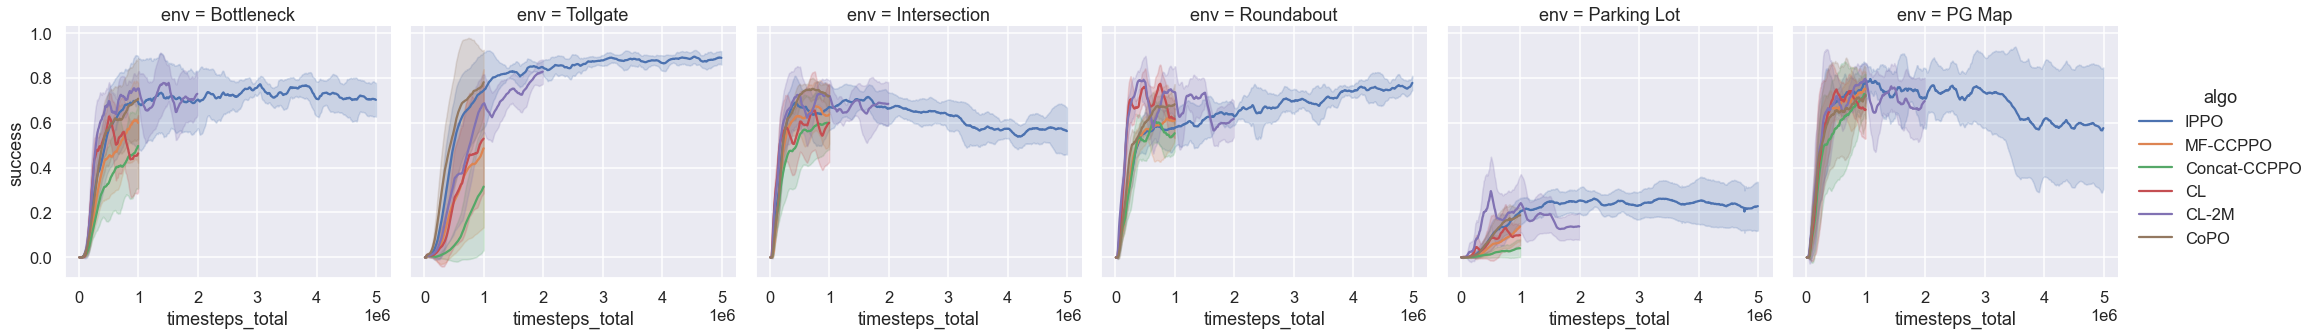

In [17]:
# Draw a little figure to see if data is processed properly.
import seaborn as sns
sns.set("talk", "darkgrid")
ax = sns.relplot(
    x="timesteps_total",
    y="success", 
    hue='algo',
    data=aggregated_data.copy(),
    ci="sd",
    kind="line",
    col="env",
)

In [18]:
aggregated_data.to_csv("aggregated_data.csv")